In [1]:
import requests

from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq


model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224").to(device='cuda')
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")


In [2]:
attribute = 'length'
from src.constants import allowed_units, entity_unit_map

<grounding> Describe this image. Give me the numeric quantities in this image, which include the number of arrows, the number and type of arrows in each arrow, and the number, type, and size of arrows.<phrase> The image</phrase><object><patch_index_0000><patch_index_1023></object> shows three arrows with different types of arrows attached to them.
Describe this image. Give me the numeric quantities in this image, which include the number of arrows, the number and type of arrows in each arrow, and the number, type, and size of arrows. The image shows three arrows with different types of arrows attached to them.
[('The image', (190, 199), [(0.015625, 0.015625, 0.984375, 0.984375)])]


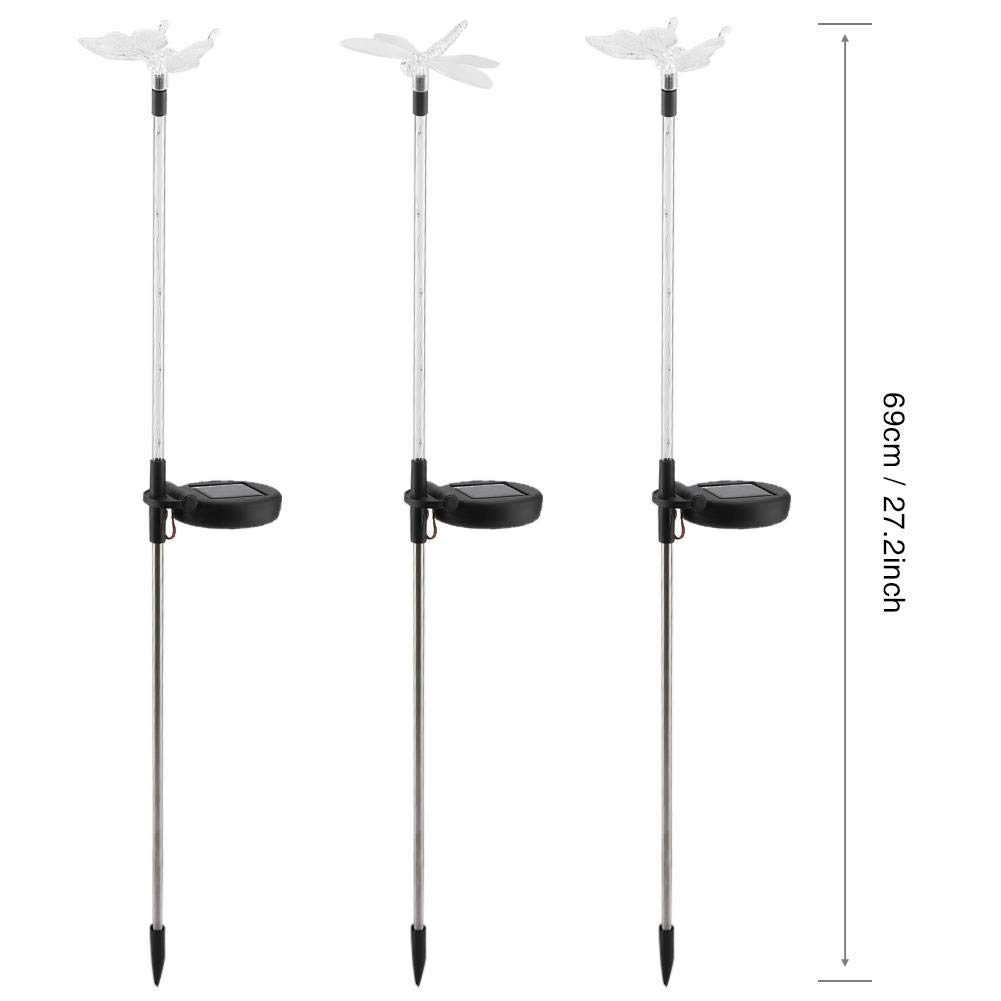

In [6]:
prompt = f"<grounding>Describe this image. Give me the numeric quantities in this image"

url = "images/41nblnEkJ3L.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# The original Kosmos-2 demo saves the image first then reload it. For some images, this will give slightly different image input and change the generation outputs.
image.save("new_image.jpg")
image = Image.open(r"images\514bY8c4ZIL.jpg")

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device='cuda')

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=128,
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Specify `cleanup_and_extract=False` in order to see the raw model generation.
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)

print(processed_text)
# `<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming himself by<phrase> a fire</phrase><object><patch_index_0005><patch_index_0911></object>.`

# By default, the generated  text is cleanup and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
# `An image of a snowman warming himself by a fire.`

print(entities)
# `[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]`
image